# Logistic regression
The purpose of this notebook is to fit logistic regression model for given dataset by implementing Newton-Raphson method and gradient descent method to minimize the cost function. Next we want to compare implemented models with *scikit-learn* model.

## Initial data analysis and visualization
First off let's import required libraries and display first few rows of dataset:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
file_name = os.path.join(os.getcwd(), 'data/Social_Network_Ads.csv')
df = pd.read_csv(file_name, engine='python')
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


Removing columns **User ID** and **Gender**, as they don't have any relevance:

In [3]:
df = df.drop(columns=['User ID', 'Gender'])
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


Checking if there are any null values in dataset:

In [4]:
df.isnull().sum()

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

Visualizing the target variable **Purchased** and exploring the data:

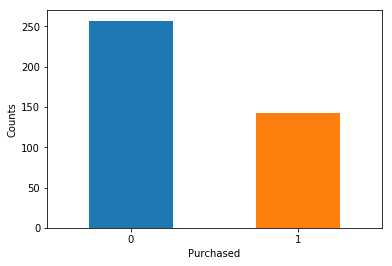

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = df['Purchased'].value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Purchased')
ax.set_ylabel('Counts')
plt.show()

In [6]:
df.groupby('Purchased').mean()

,Age,EstimatedSalary
Purchased,,
0,32.793774,60544.747082
1,46.391608,86272.727273


We can observe that people who purchased a product are generally older than people who did not. As we could expect the average of estimated salary is also higher for people that were determined to buy a product.

Visualization of the complete dataset:

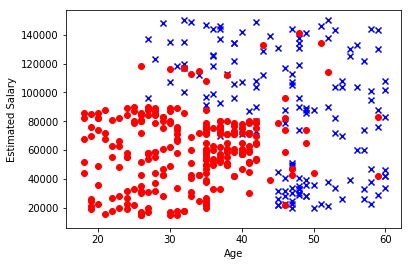

In [7]:
pos = df.loc[df['Purchased'] == 1]
neg = df.loc[df['Purchased'] == 0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos['Age'], pos['EstimatedSalary'], c='b', marker='x')
ax.scatter(neg['Age'], neg['EstimatedSalary'], c='r', marker='o')
ax.set_xlabel('Age')
ax.set_ylabel('Estimated Salary')
plt.show()

Now, we split given data into training set (80%) and testing set (20%):

In [8]:
X = df[['Age', 'EstimatedSalary']]
y = df['Purchased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In our dataset, we have big numeric values for **EstimatedSalary** field, so we have to apply feature scaling:

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In order to include the intercept term, we need to add a column of ones to the standardized features:

In [10]:
X_train_intercept = np.ones((len(X_train), 1))
X_test_intercept = np.ones((len(X_test), 1))
X_train = np.append(X_train_intercept, X_train, 1)
X_test = np.append(X_test_intercept, X_test, 1)

We convert the target variable into 2-dimensional array for easier data analysis:

In [11]:
y_train = y_train.values.reshape((-1, 1))
y_test = y_test.values.reshape((-1, 1))

## Newton-Raphson algorithm
Before we implement an algorithm, we need to define sigmoid function and cost function:

In [12]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def cost(X, y, theta):
    m = len(y)
    hypothesis = sigmoid(X@theta.T)
    term_1 = np.dot(y.T, np.log(hypothesis))
    term_2 = np.dot((1-y).T, np.log(1-hypothesis))
    J = -(term_1 + term_2)/m
    return np.float(J)

The update rule for generalized Newton-Raphson method is given by:

\begin{equation}
\theta := \theta - H^{-1}\nabla_{\theta}J(\theta),
\end{equation}

where:

\begin{equation}
H_{ij}=\frac{\partial^{2}J(\theta)}{\partial \theta_{i} \partial \theta_{j}}.
\end{equation}


In [13]:
def newton(X, y, theta, tolerance=1e-5):
    J = cost(X, y, theta)
    d_J = np.Infinity
    
    while abs(d_J) > tolerance:
        weights = sigmoid(X@theta.T)*(1-sigmoid(X@theta.T))
        weights = np.diag(weights[:, 0])
        hessian = X.T@weights@X
        gradient = X.T@(sigmoid(X@theta.T)-y)
        
        theta = theta-(np.linalg.inv(hessian)@gradient).T
        
        J_new = cost(X, y, theta)
        d_J = J-J_new
        J = J_new
    
    return theta

Now, we will train our model and make predictions for the test dataset:

In [14]:
initial_theta = np.array([[0, 0, 0]])
theta = newton(X_train, y_train, initial_theta)
prediction = sigmoid(X_test@theta.T)
for i in range(len(prediction)):
    prediction[i, 0] = 1 if prediction[i, 0] >= 0.5 else 0

To describe the performance of our model, we will construct a confusion matrix and compute parameters such as accuracy and precision:

In [15]:
def evaluate_metrics(y_true, y_pred):
    cnf = metrics.confusion_matrix(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average='macro')
    recall = metrics.recall_score(y_true, y_pred, average='macro')
    
    print(f'Accuracy: {round(accuracy*100, 2)}%')
    print(f'Precision: {round(precision*100, 2)}%')
    print(f'Recall: {round(recall*100, 2)}%')
    
    return cnf


def create_heatmap(cnf):
    heatmap = plt.imshow(cnf)
    
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 2, 1))
    ax.set_yticks(np.arange(0, 2, 1))
    ax.set_xticklabels(['positive', 'negative'])
    ax.set_yticklabels(['positive', 'negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion matrix')
    
    for i in range(np.shape(cnf)[0]):
        for j in range(np.shape(cnf)[1]):
            text = ax.text(j, i, cnf[i, j], ha='center', va='center')
    
    plt.setp(ax.get_yticklabels(), rotation=90, ha='center', rotation_mode='anchor')
    plt.colorbar(heatmap)
    plt.show()

Accuracy: 91.25%
Precision: 90.64%
Recall: 86.91%


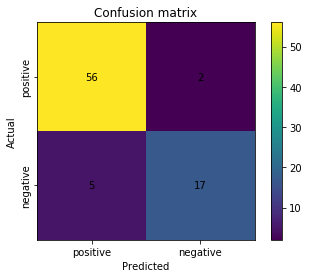

In [16]:
create_heatmap(evaluate_metrics(y_test, prediction))

## Gradient Descent Algorithm
The update rule for gradient descent algorithm is given by:

\begin{equation}
\theta := \theta - \alpha \nabla_{\theta}J(\theta)
\end{equation}


In [17]:
def gradient_descent(X, y, theta, alpha, tolerance=1e-5):
    J = cost(X, y, theta)
    d_J = np.Infinity
    
    while abs(d_J) > tolerance:
        gradient = X.T@(sigmoid(X@theta.T)-y)
        theta = theta-alpha*gradient.T
        
        J_new = cost(X, y, theta)
        d_J = J-J_new
        J = J_new
    
    return theta

Training of our model and making the predictions:

In [18]:
initial_theta = np.array([[0, 0, 0]])
alpha = 1e-3
theta = gradient_descent(X_train, y_train, initial_theta, alpha)
prediction = sigmoid(X_test@theta.T)
for i in range(len(prediction)):
    prediction[i, 0] = 1 if prediction[i, 0] >= 0.5 else 0

Checking the efficiency of our model:

Accuracy: 91.25%
Precision: 90.64%
Recall: 86.91%


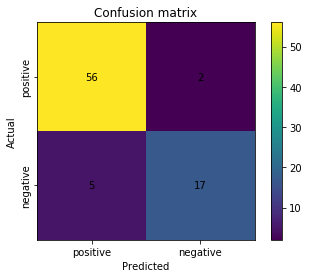

In [19]:
create_heatmap(evaluate_metrics(y_test, prediction))

As we can see, the efficiency of model created by gradient descent method is the same as efficiency of model created with Newton-Raphson method. Now, we will check *scikit-learn* logistic regression model.

## *Scikit-learn* model
Instantiating and training Logistic Regression model:

In [20]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.reshape(-1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Making the predictions:

In [21]:
prediction = logreg.predict(X_test)

Model evaluation using confusion matrix:

Accuracy: 91.25%
Precision: 90.64%
Recall: 86.91%


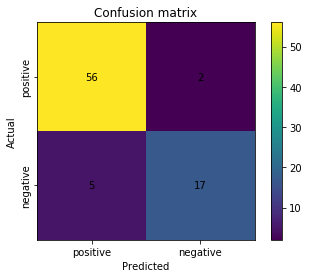

In [22]:
create_heatmap(evaluate_metrics(y_test, prediction))

We can see *sci-kit* model offers the same performance as implemented Newton-Raphson algorithm and Gradient Descent algorithm, but it is much easier in use. Also it doesn't need data to be standardized.

Now, we can plot the Receiver Operator Characteristic (ROC) and check the Area Under Curve (AUC) to specify how good is our classifier model (1 score represents perfect classifier and 0.5 means that it is worthless):

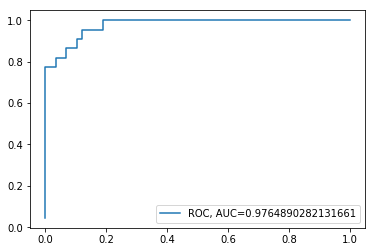

In [23]:
pred_probability = logreg.predict_proba(X_test)[:,1].reshape(-1, 1)
fpr, tpr, _ = metrics.roc_curve(y_test, pred_probability)
auc = metrics.roc_auc_score(y_test, pred_probability)
plt.plot(fpr, tpr, label="ROC, AUC="+str(auc))
plt.legend()
plt.show()

As we can see AUC score is very close to 1 so it means our classifier is quite good.